## Extinction risks for cartilaginous fish

An exploration of some of the results in [Extinction risk is most acute for the world’s largest and smallest vertebrates](https://www.pnas.org/content/114/40/10678), Ripple et al., PNAS October 3, 2017 114 (40) 10678-10683

Specifically, we'll investigate how extinction risks vary by weight for cartilaginous fish. This provides some nice practice with simple linear and logistic regression, with the overall goal of explaining basic diagnostics for both methods. 

All of this (and more!) is in Chapters 2-5 of my Manning book, [Regression: A friendly guide](https://www.manning.com/books/regression-a-friendly-guide). 

This notebook and the relevant CSVs are available in my [regression repo on github](https://github.com/mbrudd/regression), along with other code and data for the book. Code and fork at will!

### Imports and settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme()
plt.rcParams['figure.figsize'] = [8,8]

### Data

First things first: we need data! Thanks to the good people at [ROpenSci](https://ropensci.org/), the data from [Fishbase.org](https://www.fishbase.se/search.php) is easily available in the [rfishbase](https://docs.ropensci.org/rfishbase/index.html) package.


In [4]:
fish = pd.read_csv("fish.csv")
fish.shape

(34299, 101)

In [5]:
fish.columns

Index(['SpecCode', 'Species', 'Genus', 'SpeciesRefNo', 'Author', 'FBname',
       'PicPreferredName', 'PicPreferredNameM', 'PicPreferredNameF',
       'PicPreferredNameJ',
       ...
       'Profile', 'PD50', 'Emblematic', 'Entered', 'DateEntered', 'Modified',
       'DateModified', 'Expert', 'DateChecked', 'TS'],
      dtype='object', length=101)

In [6]:
fish = fish.filter(["Species","Length","Weight"])
fish

,Species,Length,Weight
0,Aapticheilichthys websteri,3.08,NaN
1,Aaptosyax grypus,130.00,30000.0
2,Abactochromis labrosus,11.50,NaN
3,Abalistes filamentosus,32.50,1375.0
4,Abalistes stellaris,60.00,NaN
...,...,...,...
34294,Zu cristatus,118.00,NaN
34295,Zu elongatus,120.00,NaN
34296,Zungaro jahu,140.00,NaN
34297,Zungaro zungaro,140.00,NaN


In [7]:
train = fish.dropna(axis='index')
train

,Species,Length,Weight
1,Aaptosyax grypus,130.0,30000.0
3,Abalistes filamentosus,32.5,1375.0
9,Abbottina obtusirostris,10.9,13.5
14,Ablennes hians,140.0,4800.0
24,Abramis brama,82.0,6010.0
...,...,...,...
34265,Zeus faber,90.0,8000.0
34266,Zingel asper,22.0,100.0
34270,Zoarces americanus,110.0,5436.0
34273,Zoarces fedorovi,23.0,92.0


Text(0.5, 1.0, 'Fish weights versus fish lengths')

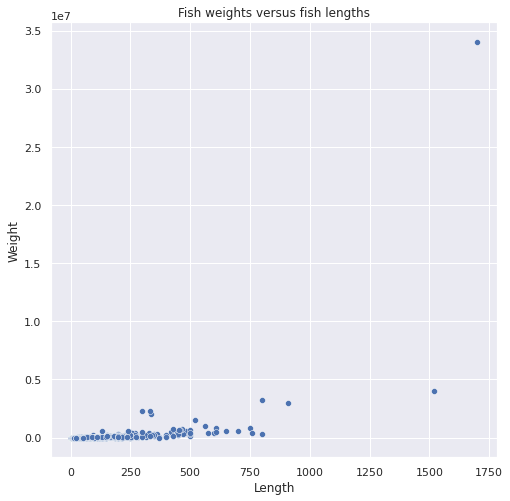

In [8]:
sns.scatterplot(data=train, x="Length", y="Weight")
plt.title("Fish weights versus fish lengths")

In [9]:
train = train.assign(LogLength = np.log(train.Length), LogWeight = np.log(train.Weight))

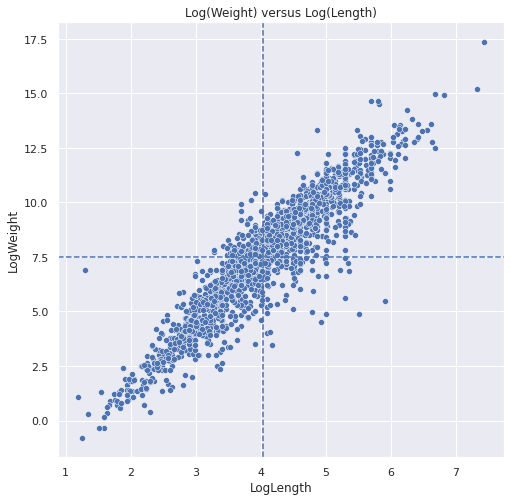

In [10]:
sns.scatterplot(data=train, x="LogLength", y="LogWeight")
plt.title("Log(Weight) versus Log(Length)")
plt.axvline( np.mean( train["LogLength"] ), linestyle='--')
plt.axhline( np.mean( train["LogWeight"] ), linestyle='--')

### Linear regression

The basic metric for the strength of a _linear_ relationship is the _correlation coefficient_:


In [11]:
train.LogLength.corr( train.LogWeight )

0.9230692454775016

This is a very strong correlation! In real life, especially in the social sciences, correlations between .3 and .7 in magnitude are much more common. Having checked the linear relationship, let's fit the regression line:


In [12]:
train_model = smf.ols( "LogWeight ~ LogLength", data=train)
train_fit = train_model.fit()
train_fit.params

Intercept   -3.322617
LogLength    2.681095
dtype: float64


This model says that 

$$ \log{ \left( \text{Weight} \right) } ~ = ~ -3.322617 + 2.681095 \times \log{ \left( \text{Length} \right) } \ ,$$

which is easier to digest after exponentiating:

$$ \text{Weight} ~ = ~ e^{-3.322617} \times \text{Length}^{2.681095} ~ = ~ 0.036 \times \text{Length}^{2.681095} \ .$$

This _power law relationship_ says that weight is roughly proportional to the cube of the length!

***

The _null model_ predicts that _every_ needed/unseen weight equals the average of the known weights:


In [13]:
np.mean( fish["Weight"] )

44594.08062820512

In [14]:
np.log( np.mean( fish["Weight"] ) )

10.705356407859206

Is the regression model better than this at predicting weights? Answering this specific question is the job of the _coefficient of determination_, denoted $R^2$. 

$$R^2 ~ = ~ \frac{ \text{TSS} - \text{SSR} }{ \text{TSS} } ~ = ~ 1 - \frac{ \text{SSR} }{ \text{TSS} }$$

You could compute it this way...

In [15]:
( train_fit.centered_tss - train_fit.ssr) / train_fit.centered_tss

0.852056831946404


but don't! It's already provided:


In [16]:
train_fit.rsquared

0.852056831946404

### Sharks!

The information we need about [cartilaginous fish](https://en.wikipedia.org/wiki/Chondrichthyes) (sharks, rays, skates, sawfish, ghost sharks) comes from the [IUCN Red List](https://www.iucnredlist.org/):

In [17]:
sharks = pd.read_csv("chondrichthyes.csv")
sharks

,Species,Category
0,Hexanchus griseus,Near Threatened
1,Lamna nasus,Vulnerable
2,Leucoraja lentiginosa,Least Concern
3,Dactylobatus clarkii,Least Concern
4,Pseudobatos percellens,Endangered
...,...,...
1181,Squatina californica,Near Threatened
1182,Urogymnus granulatus,Vulnerable
1183,Dipturus lamillai,Least Concern
1184,Hypanus berthalutzae,Vulnerable


In [18]:
sharks = sharks.join( fish.set_index("Species"), on="Species")
sharks

,Species,Category,Length,Weight
0,Hexanchus griseus,Near Threatened,482.0,590000.0
1,Lamna nasus,Vulnerable,350.0,230000.0
2,Leucoraja lentiginosa,Least Concern,43.0,NaN
3,Dactylobatus clarkii,Least Concern,59.0,NaN
4,Pseudobatos percellens,Endangered,100.0,955.1
...,...,...,...,...
1181,Squatina californica,Near Threatened,152.0,NaN
1182,Urogymnus granulatus,Vulnerable,141.0,NaN
1183,Dipturus lamillai,Least Concern,NaN,NaN
1184,Hypanus berthalutzae,Vulnerable,NaN,NaN


In [19]:
sharks = sharks[ sharks.Length.notna() ]
sharks = sharks[ sharks.Category != "Data Deficient" ]
sharks

,Species,Category,Length,Weight
0,Hexanchus griseus,Near Threatened,482.0,590000.0
1,Lamna nasus,Vulnerable,350.0,230000.0
2,Leucoraja lentiginosa,Least Concern,43.0,NaN
3,Dactylobatus clarkii,Least Concern,59.0,NaN
4,Pseudobatos percellens,Endangered,100.0,955.1
...,...,...,...,...
1179,Pateobatis jenkinsii,Vulnerable,130.0,NaN
1180,Pristiophorus cirratus,Least Concern,137.0,NaN
1181,Squatina californica,Near Threatened,152.0,NaN
1182,Urogymnus granulatus,Vulnerable,141.0,NaN


### Data imputation

Use the power law relationship to _impute_ the missing weights:


In [20]:
imp = np.exp( train_fit.params.Intercept )*np.power( sharks.Length, train_fit.params.LogLength )
sharks.Weight = sharks.Weight.where( sharks.Weight.notna(), imp )
sharks

,Species,Category,Length,Weight
0,Hexanchus griseus,Near Threatened,482.0,590000.000000
1,Lamna nasus,Vulnerable,350.0,230000.000000
2,Leucoraja lentiginosa,Least Concern,43.0,863.950740
3,Dactylobatus clarkii,Least Concern,59.0,2017.563809
4,Pseudobatos percellens,Endangered,100.0,955.100000
...,...,...,...,...
1179,Pateobatis jenkinsii,Vulnerable,130.0,16775.968002
1180,Pristiophorus cirratus,Least Concern,137.0,19308.807587
1181,Squatina californica,Near Threatened,152.0,25511.414447
1182,Urogymnus granulatus,Vulnerable,141.0,20857.643324


In [21]:
sharks = sharks.assign(LogLength = np.log(sharks.Length), 
                       LogWeight = np.log(sharks.Weight))

Text(0.5, 1.0, 'Log(Weight) versus Log(Length) for sharks')

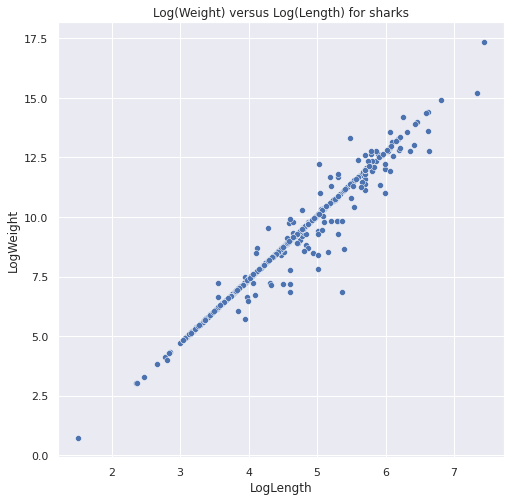

In [22]:
sns.scatterplot( data=sharks, x="LogLength", y="LogWeight")
plt.title("Log(Weight) versus Log(Length) for sharks")

In [23]:
sharks

,Species,Category,Length,Weight,LogLength,LogWeight
0,Hexanchus griseus,Near Threatened,482.0,590000.000000,6.177944,13.287878
1,Lamna nasus,Vulnerable,350.0,230000.000000,5.857933,12.345835
2,Leucoraja lentiginosa,Least Concern,43.0,863.950740,3.761200,6.761516
3,Dactylobatus clarkii,Least Concern,59.0,2017.563809,4.077537,7.609646
4,Pseudobatos percellens,Endangered,100.0,955.100000,4.605170,6.861816
...,...,...,...,...,...,...
1179,Pateobatis jenkinsii,Vulnerable,130.0,16775.968002,4.867534,9.727703
1180,Pristiophorus cirratus,Least Concern,137.0,19308.807587,4.919981,9.868317
1181,Squatina californica,Near Threatened,152.0,25511.414447,5.023881,10.146881
1182,Urogymnus granulatus,Vulnerable,141.0,20857.643324,4.948760,9.945476


In [24]:
threatened = ["Critically Endangered","Endangered","Vulnerable"]

In [25]:
sharks["Threatened"] = sharks["Category"].isin( threatened ).astype('int')
sharks = sharks.drop(columns = "Category")
sharks

,Species,Length,Weight,LogLength,LogWeight,Threatened
0,Hexanchus griseus,482.0,590000.000000,6.177944,13.287878,0
1,Lamna nasus,350.0,230000.000000,5.857933,12.345835,1
2,Leucoraja lentiginosa,43.0,863.950740,3.761200,6.761516,0
3,Dactylobatus clarkii,59.0,2017.563809,4.077537,7.609646,0
4,Pseudobatos percellens,100.0,955.100000,4.605170,6.861816,1
...,...,...,...,...,...,...
1179,Pateobatis jenkinsii,130.0,16775.968002,4.867534,9.727703,1
1180,Pristiophorus cirratus,137.0,19308.807587,4.919981,9.868317,0
1181,Squatina californica,152.0,25511.414447,5.023881,10.146881,0
1182,Urogymnus granulatus,141.0,20857.643324,4.948760,9.945476,1


In [26]:
null_prob = np.mean(sharks["Threatened"])
null_prob

0.34610630407911

In [27]:
sharks_model = smf.glm("Threatened ~ LogWeight", data=sharks, family=sm.families.Binomial())
sharks_fit = sharks_model.fit()
sharks_fit.params

Intercept   -3.173571
LogWeight    0.293120
dtype: float64

- For logistic models, the _deviance_ is analogous to the sum of squared residuals in linear regression analysis. 

- The _likelihood ratio statistic_ compares the deviances of the simple logistic model and the null model and is analogous to the coefficient of determination.  

- Unlike the coefficient of determination, the likelihood ration statistic defies easy interpretation. It's easy to gauge its size, though, as it is a $\chi^2$ statistic with $df=1$ (_why_ this is true is another story...).

In [28]:
1 - chi2.cdf(sharks_fit.null_deviance - sharks_fit.deviance, df=1)

8.770761894538737e-15


This is astronomically small -- the logistic model that includes `LogLength` is better than the null model that ignores it!

And if we plot the results, things look pretty good:


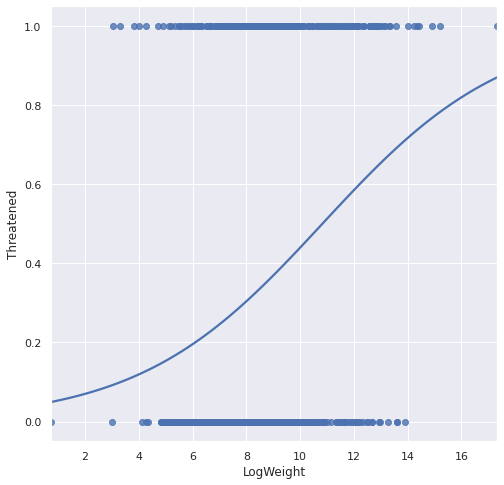

In [29]:
sns.regplot(data=sharks, x="LogWeight", y="Threatened", logistic=True, ci=None)
plt.savefig("sharks_fit.png")

### Model assessment 

Ripple et al. stop here with this particular model, but they should have assessed it carefully. We'll look at two options.


#### Binary classification and the ROC curve

In [30]:
sharks["Class"] = (sharks_fit.fittedvalues > 0.50).astype(int)
sharks

,Species,Length,Weight,LogLength,LogWeight,Threatened,Class
0,Hexanchus griseus,482.0,590000.000000,6.177944,13.287878,0,1
1,Lamna nasus,350.0,230000.000000,5.857933,12.345835,1,1
2,Leucoraja lentiginosa,43.0,863.950740,3.761200,6.761516,0,0
3,Dactylobatus clarkii,59.0,2017.563809,4.077537,7.609646,0,0
4,Pseudobatos percellens,100.0,955.100000,4.605170,6.861816,1,0
...,...,...,...,...,...,...,...
1179,Pateobatis jenkinsii,130.0,16775.968002,4.867534,9.727703,1,0
1180,Pristiophorus cirratus,137.0,19308.807587,4.919981,9.868317,0,0
1181,Squatina californica,152.0,25511.414447,5.023881,10.146881,0,0
1182,Urogymnus granulatus,141.0,20857.643324,4.948760,9.945476,1,0


In [31]:
pd.crosstab(sharks["Threatened"], sharks["Class"])

Class,0,1
Threatened,,
0,492,37
1,211,69


In [32]:
np.mean( sharks["Threatened"] == sharks["Class"] )

0.6934487021013597

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(sharks["Threatened"], sharks_fit.fittedvalues)
chronic_auc = metrics.auc(fpr, tpr)
chronic_auc

0.6589994598973805

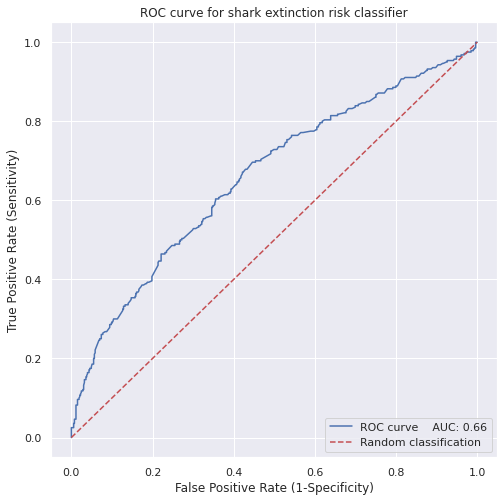

In [34]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve    AUC: %0.2f' % chronic_auc)
plt.plot([0,1], [0,1], 'r--', label='Random classification')
# plt.xlim([0, 1]) 
# plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve for shark extinction risk classifier')
plt.legend(loc="lower right")

#### Logistic analogues of $R^2$

_McFadden's pseudo_-$R^2$ : replace sums of squares with deviances to measure the proportional reduction in the deviance

In [35]:
R2_M = 1 - (sharks_fit.deviance / sharks_fit.null_deviance)
R2_M

0.05764873271492332


Or use the native sums of squares in this context:


In [36]:
sharks["Null_residual"] = sharks["Threatened"] - null_prob
sharks["Residual"] = sharks["Threatened"] - sharks_fit.fittedvalues
sharks["Difference"] = sharks_fit.fittedvalues - null_prob
R2_S = np.sum(sharks["Difference"]**2) / np.sum(sharks["Null_residual"]**2)
R2_S

0.07391985741684046


Or compute _Tjur's coefficient of discrimination_: a good model should, on average, assign high probabilities to observed successes (1's) and low probabilities to observed failures (0's)


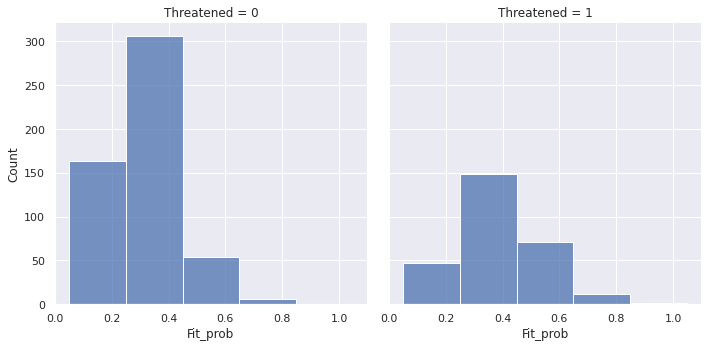

In [37]:
sharks["Fit_prob"] = sharks_fit.fittedvalues
sns.displot( data=sharks, x="Fit_prob", col="Threatened", binwidth=0.2)

In [38]:
fit_avgs = sharks.groupby("Threatened").agg(Fit_average=('Fit_prob','mean'))
fit_avgs

,Fit_average
Threatened,
0,0.319667
1,0.396059


In [39]:
R2_D = fit_avgs["Fit_average"][1] - fit_avgs["Fit_average"][0]
R2_D

0.07639201019244374

Yikes! Not a very good model after all. :(